# Analysis of library composition compaired to training data and all possible sites. 

## 1. Concant ST & Y datasets

In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [3]:
ST_set = pd.read_csv("/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv") 
Y_set = pd.read_csv("/home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_2,7,30_Preds.csv")

In [4]:
# Concatenate the two DataFrames vertically
combined_df = pd.concat([ST_set, Y_set], axis=0, ignore_index=True)
# Sort the combined DataFrame by protein ID and position
combined_df = combined_df.sort_values(['prot_id', 'position'])
# Reset the index after sorting
combined_df = combined_df.reset_index(drop=True)

## 2. Transform train, test, valid set into dataframe

In [5]:
def get_sites(filenames):
    """
    Input: 
        >Q9BSJ6
        MASRWQNMGT@S#VRRRS#LQHQEQLEDS@KELQPVVS@HQET@S@VGALGSLCRQFQRRLPLRAVNLNLRAGPSWKRLET#PEPGQQGLQAAARSAKS#ALGAVS@QRIQES@C...
        >...

    Processing: 
        Target sites are annotated with tailing symbols: @ means no modification has been found, # means modification on this residue has been found.
        The challenge here is to correctly determine the position of the amino acid without counting the annotations: # and @. 
        Only put a site in the dataframe when it has a positive annotation.  
        
    Output: 
        pandas dataframe:
        prot_id, position
        Q9BSJ6, 11
        Q9BSJ6, 16
        ...
    """
    sites = []
    current_protein = None

    # Iterate over each file
    for filename in filenames:
        current_protein = None
            
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                
                # Handle protein ID lines (starting with >)
                if line.startswith('>'):
                    current_protein = line[1:]  # Remove the '>' character
                    continue
                    
                # Handle sequence lines
                if current_protein and line:
                    # Initialize position counter (not counting annotations)
                    true_position = 0
                    
                    # Iterate through the sequence
                    for i, char in enumerate(line):
                        if char not in ['@', '#']:
                            # Increment position for actual amino acids
                            true_position += 1
                        elif char == '#':
                            # Add to our sites list
                            sites.append({
                                'prot_id': current_protein,
                                'position': true_position
                            })
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(sites)
    
    # Sort by protein ID and position
    df = df.sort_values(['prot_id', 'position']).reset_index(drop=True)
    
    return df

In [6]:
train_ST = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_ST.fasta"
train_Y = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_Y.fasta"
# need to combine ST & Y:
train_sites = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_combined.fasta"

with open(train_sites, "w") as outfile:
    for file in [train_ST, train_Y]:
        with open(file, "r") as infile:
            outfile.write(infile.read() + "\n")  # Voeg een nieuwe regel toe om records goed te scheiden

print(f"Combined FASTA saved to: {train_sites}")

Combined FASTA saved to: /home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_combined.fasta


# small test

st => 46 000 training examples
y => only 4000? 

==> inderdeed the case

In [7]:
def count_hashes_in_fasta(file_path):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            count += line.count('@')
    return count

In [8]:
print(count_hashes_in_fasta(train_ST))

279066


In [9]:
print(count_hashes_in_fasta(train_Y))

51723


## End test

In [10]:
train_sites = get_sites([train_sites])
train_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50271 entries, 0 to 50270
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prot_id   50271 non-null  object
 1   position  50271 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 785.6+ KB


In [11]:
train_sites.head()

,prot_id,position
0,A0A087WUL8,364
1,A0A096LP49,519
2,A0AVK6,52
3,A0AVK6,58
4,A0AVK6,71


## Combine the whole PhosphoSite compendium:  

In [12]:
valid_Y = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/valid_Y.fasta"
test_Y = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/test_Y.fasta"
valid_ST = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/valid_ST.fasta"
test_ST = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/test_ST.fasta"

compendium = [train_Y, valid_Y, test_Y, train_ST, valid_ST, test_ST]
compendium_sites = get_sites(compendium)
compendium_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59105 entries, 0 to 59104
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prot_id   59105 non-null  object
 1   position  59105 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 923.6+ KB


In [13]:
compendium_sites.head()

,prot_id,position
0,A0A087WUL8,364
1,A0A096LP49,519
2,A0AV96,519
3,A0AVK6,52
4,A0AVK6,58


# 3. Cross-reference sites and add new columns

## in_training

In [14]:
def add_reference_indicator(df, reference_df, column_name):
    """
    Add indicator column to df based on presence in reference_df
    
    Args:
        df (pd.DataFrame): Main DataFrame to add indicator to
        reference_df (pd.DataFrame): Reference DataFrame to check against
        column_name (str): Name of the new indicator column
        
    Returns:
        pd.DataFrame: df with additional indicator column
    """
    # Make sure both DataFrames have the same column types
    df['position'] = df['position'].astype(int)
    reference_df['position'] = reference_df['position'].astype(int)
    
    # Create a temporary key for matching
    df['temp_key'] = df['prot_id'] + '_' + df['position'].astype(str)
    reference_df['temp_key'] = reference_df['prot_id'] + '_' + reference_df['position'].astype(str)
    
    # Create the indicator column (default 0)
    df[column_name] = 0
    
    # Set to 1 where the combination exists in reference_df
    df.loc[df['temp_key'].isin(reference_df['temp_key']), column_name] = 1
    
    # Remove temporary key
    df = df.drop('temp_key', axis=1)
    
    return df

In [15]:
# First add the training indicator
result_df = add_reference_indicator(combined_df, train_sites, 'in_training')

#see both 0 and 1 counts
distribution = result_df['in_training'].value_counts()
print("\nDistribution of sites:")
print(distribution)


Distribution of sites:
0    1414138
1      48475
Name: in_training, dtype: int64


In [16]:
# Then add the compendium indicator
result_df = add_reference_indicator(result_df, compendium_sites, 'Archive')

#see both 0 and 1 counts
distribution = result_df['Archive'].value_counts()
print("\nDistribution of sites:")
print(distribution)


Distribution of sites:
0    1405605
1      57008
Name: Archive, dtype: int64


# 4. Venn DiaGram

In [17]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import numpy as np

def plot_venn_diagram(results_df, score_threshold):
    """
    Create a Venn diagram with custom colors, borders, and better text placement
    """
    # Get sets
    all_sites = set(results_df['prot_id'] + '_' + results_df['position'].astype(str))
    above_threshold = set(results_df[results_df['pred'] >= score_threshold]['prot_id'] + '_' + 
                         results_df[results_df['pred'] >= score_threshold]['position'].astype(str))
    training_sites = set(results_df[results_df['in_training'] == 1]['prot_id'] + '_' + 
                        results_df[results_df['in_training'] == 1]['position'].astype(str))
    
    # Create figure
    plt.figure(figsize=(6, 6))
    
    # Create Venn diagram with custom colors - remove all default labels
    v = venn3([all_sites, above_threshold, training_sites], 
              ('', '', ''),  # Remove all default labels
              set_colors=('red', 'lightgreen', 'blue'))
    
    # Add darker borders to the circles
    for patch in v.patches:
        if patch is not None:
            patch.set_edgecolor('darkgray')
            patch.set_linewidth(2.0)
    
    # Add all text labels manually
    plt.text(0.75, 0.72, f'Sites with Score ≥ {score_threshold}', 
            horizontalalignment='center', 
            verticalalignment='center',
            transform=plt.gca().transAxes,
            fontsize=18)
    
    # Add 'All sites' label
    plt.text(0.15, 0.95, f'All sites\n({len(all_sites):,})', 
            horizontalalignment='center', 
            verticalalignment='center',
            transform=plt.gca().transAxes,
            fontsize=18)
    
    # Add 'Training sites' label
    plt.text(0.85, 0.27, 'Training sites', 
            horizontalalignment='center', 
            verticalalignment='center',
            transform=plt.gca().transAxes,
            fontsize=18)
    
    plt.show()

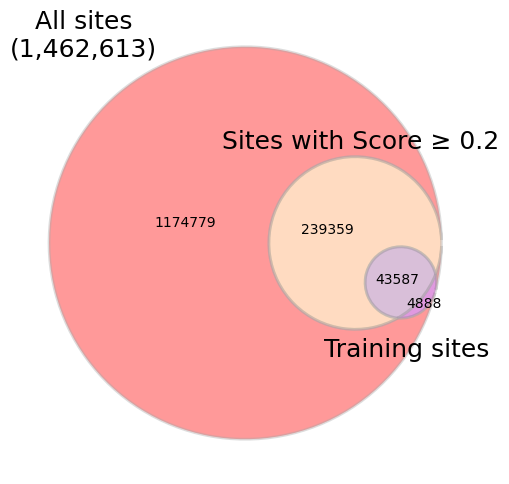

In [18]:
plot_venn_diagram(result_df, score_threshold=0.20)

# 4. Get Sites from results of the analysis

from result tables to "prot_id, position, localisation_score"
Only in the table when: 
> Qval & PEP >= 0.01

In [19]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

canonical_proteome = '/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta'
proteome = read_proteome(canonical_proteome)

def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a single protein sequence.

    Args:
        sequence (str): Protein sequence
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length (None for no limit)

    Returns:
        list: List of tuples (peptide, start_pos) where start_pos is 0-based

    Example:
        Input: "PEPTIDERPRRPEPTIDE"
        Output: [('PEPTIDER', 0), ('PEPTIDERR', 0), ..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R'): # and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                # Validate that the peptide actually starts at pep_start
                assert sequence[pep_start:pep_start+len(peptide)] == peptide
                peptides.append((peptide, pep_start))
    return peptides

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    Args:
        peptide_seq (str): Peptide sequence
        protein_seq (str): Full protein sequence
        start_pos (int): Start position of peptide in protein (0-based)

    Returns:
        int: Number of missed cleavages

    Example:
        Input: ('PEPTIDERPR', 'PEPTIDERPRRPEPTIDE', 0)
        Output: 1
    """
    # Validate that the peptide actually occurs at start_pos
    assert protein_seq[start_pos:start_pos+len(peptide_seq)] == peptide_seq, \
           f"Peptide {peptide_seq} not found at position {start_pos} in protein"
    
    miscleavages = 0
    for i in range(len(peptide_seq)-1):  # Changed range to avoid going past peptide end
        abs_pos = start_pos + i  # Removed the -1 offset
        if protein_seq[abs_pos] in ('K', 'R'):
            miscleavages += 1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    Args:
        sequences (dict): Dictionary of protein sequences {prot_id: sequence}
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length

    Returns:
        list: List of dictionaries containing peptide information
        
    Example:
        Input: {'prot1': 'PEPTIDERRRPEPTIDE...', ...}
        Output: [{'prot_id': 'prot1', 'sequence': 'PEPTIDERPR', 'miscleavages': 1, 
                 'peptide_length': 10, 'start_pos': 0}, ...]
    """
    digested_peptides = []
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            # Validate peptide position
            assert seq[start_pos:start_pos+len(peptide)] == peptide, \
                   f"Position mismatch for peptide {peptide} in protein {prot_id}"
            
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

peptides = trypsin_digest(sequences = proteome, missed_cleavages = 2, min_length = 7, max_length = 30)

In [20]:
orbitrap = pd.read_parquet("/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet")

when specifying residu:

In [21]:
from tqdm import tqdm
import pandas as pd

def results_to_sites(diann_results, peptides):
    """
    Process DIANN proteomics results to identify tyrosine phosphorylation sites.
    Only processes Y(UniMod:21) modifications, excluding S(UniMod:21) and T(UniMod:21)
    even when they appear in the same peptide.
    
    Args:
        diann_results (pd.DataFrame): DataFrame with DIANN results.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Processed results with phosphotyrosine site information only.
    """
    # Create a dictionary for faster peptide lookup 
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    # 1. Filter results for quality first
    filtered_data = diann_results[
        (diann_results['Global.Peptidoform.Q.Value'] <= 0.01)
    ].copy()
    
    results = []
    
    # 2. Process each peptidoform with a progress bar
    for idx, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], desc='Processing phosphotyrosine sites'):
        stripped_seq = row['Stripped.Sequence']
        prob_string = row['Site.Occupancy.Probabilities']
        
        # Skip if there's no Y(UniMod:21) in the probability string
        if 'Y(UniMod:21)' not in row['Modified.Sequence']:
            continue
            
        # Find matching reference peptides
        matches = peptide_dict.get(stripped_seq, [])
        if not matches:
            print(f"Warning: No matching reference for {stripped_seq}")
            continue
            
        relative_pos = 0
        i = 0
        
        while i < len(prob_string):
            char = prob_string[i]
            
            if char.isalpha():  # Amino acid
                relative_pos += 1
                i += 1
                continue
                
            if char == '(':
                # Find the complete modification
                mod_end = prob_string.find(')', i)
                mod_type = prob_string[i:mod_end+1]
                
                # Check if this is a Y(UniMod:21) modification
                if i > 0 and prob_string[i-1] == 'Y' and mod_type == '(UniMod:21)':
                    # Look for the corresponding score
                    score_start = prob_string.find('{', mod_end)
                    if score_start != -1:
                        score_end = prob_string.find('}', score_start)
                        try:
                            current_score = float(prob_string[score_start+1:score_end])
                            # Add entry for each matching protein
                            for match in matches:
                                results.append({
                                    'prot_id': match['prot_id'],
                                    'position': match['start_pos'] + relative_pos - 1,  # -1 because we already incremented
                                    'Q.Value': row['Global.Peptidoform.Q.Value'],
                                    'PEP': row['PEP'],
                                    'Localisation_score': current_score,
                                    'shared': 1 if len(matches) > 1 else 0
                                })
                        except ValueError:
                            print(f"Warning: Unable to convert score {prob_string[score_start+1:score_end]} to float.")
                
                # Skip to end of modification
                i = mod_end + 1
                continue
                
            elif char == '{':  # Skip score blocks if we haven't processed them yet
                score_end = prob_string.find('}', i)
                i = score_end + 1
                continue
                
            i += 1
    
    # Convert results to DataFrame and remove duplicates
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('Localisation_score', ascending=False)
        results_df = results_df.drop_duplicates(subset=['prot_id', 'position'], keep='first')
    
    return results_df

when not specifying residu:

In [22]:
from tqdm import tqdm
import pandas as pd

def results_to_sites(diann_results, peptides):
    """
    Process DIANN proteomics results to identify phosphorylation sites.
    
    Args:
        diann_results (pd.DataFrame): DataFrame with DIANN results.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Processed results with phosphosite information.
    """
    # Create a dictionary for faster peptide lookup 
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    # 1. Filter results
    filtered_data = diann_results[
        (diann_results['Global.Peptidoform.Q.Value'] <= 0.01) & 
        (diann_results['Modified.Sequence'].str.contains('UniMod:21'))
    ].copy()
    
    results = []
    
    # 2. Process each peptidoform with a progress bar
    for idx, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], desc='Processing peptidoforms'):
        stripped_seq = row['Stripped.Sequence']
        
        # Find matching reference peptides
        matches = peptide_dict.get(stripped_seq, [])
        if not matches:
            print(f"Warning: No matching reference for {stripped_seq}")
            continue
            
        relative_pos = 0
        prob_string = row['Site.Occupancy.Probabilities']
        i = 0
        
        while i < len(prob_string):
            char = prob_string[i]
            
            if char.isalpha():  # Amino acid
                relative_pos += 1
                i += 1
            elif char == '(':  # Modification marker, skip until ')'
                while i < len(prob_string) and prob_string[i] != ')':
                    i += 1
                i += 1  # Skip the closing ')'
            elif char == '{':  # Localization score block
                score_end = prob_string.find('}', i)
                try:
                    current_score = float(prob_string[i+1:score_end])
                    # Add entry for each matching protein
                    for match in matches:
                        results.append({
                            'prot_id': match['prot_id'],
                            'position': match['start_pos'] + relative_pos,
                            'Q.Value': row['Global.Peptidoform.Q.Value'],
                            'PEP': row['PEP'],
                            'Localisation_score': current_score,
                            'shared': 1 if len(matches) > 1 else 0  # Mark as shared if more than one match
                        })
                except ValueError:
                    print(f"Warning: Unable to convert score {prob_string[i+1:score_end]} to float.")
                i = score_end + 1
            else:
                i += 1
    
    # Convert results to DataFrame and remove duplicates (keeping highest localisation score per site)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Localisation_score', ascending=False)
    results_df = results_df.drop_duplicates(subset=['prot_id', 'position'], keep='first')
    
    return results_df


In [23]:
orbitrap_sites = results_to_sites(orbitrap, peptides)

Processing peptidoforms: 100%|██████████| 3681/3681 [00:00<00:00, 24656.62it/s]


In [24]:
orbitrap[orbitrap["Protein.Ids"] == "A0MZ66"]

,Run.Index,Run,Channel,Precursor.Id,Precursor.Channels.Group,Modified.Sequence,Stripped.Sequence,Precursor.Charge,Precursor.Lib.Index,Proteotypic,Precursor.Mz,Protein.Ids,Protein.Group,Protein.Names,Genes,RT,iRT,Predicted.RT,Predicted.iRT,IM,iIM,Predicted.IM,Predicted.iIM,Precursor.Quantity,Precursor.Normalised,Ms1.Area,Ms1.Normalised,Ms1.Apex.Area,Ms1.Apex.Mz.Delta,Normalisation.Factor,Quantity.Quality,Empirical.Quality,Normalisation.Noise,Ms1.Profile.Corr,Averagine,Evidence,Mass.Evidence,Ms1.Total.Signal.Before,Ms1.Total.Signal.After,RT.Start,RT.Stop,FWHM,PG.Normalised,PG.MaxLFQ,Genes.Normalised,Genes.MaxLFQ,Genes.MaxLFQ.Unique,PG.MaxLFQ.Quality,Q.Value,PEP,Global.Q.Value,Lib.Q.Value,Peptidoform.Q.Value,Global.Peptidoform.Q.Value,Lib.Peptidoform.Q.Value,PTM.Q.Value,PTM.Site.Confidence,Site.Occupancy.Probabilities,Protein.Sites,Lib.PTM.Site.Confidence,Translated.Q.Value,Channel.Q.Value,PG.Q.Value,PG.PEP,GG.Q.Value,Protein.Q.Value,Global.PG.Q.Value,Lib.PG.Q.Value
31019,2,Orbitrap_Exploris_480_Phospho_Enriched_03,,RQS(UniMod:21)HLLLQSSIPDQQLLK3,RQS(UniMod:21)HLLLQSSIPDQQLLK3,RQS(UniMod:21)HLLLQSSIPDQQLLK,RQSHLLLQSSIPDQQLLK,3,32915651,1,728.723267,A0MZ66,A0MZ66,SHOT1_HUMAN,SHTN1,21.125256,67.860535,22.197933,62.827793,0.0,542.745850,0.0,0.0,4340693.0,3381634.25,2925144.00,2278845.00,2888913.5,0.011593,0.779054,0.000000,0.000000,0.000000,0.991669,1.0,4.300599,0.000000,1.398675e+09,1.900958e+09,21.012001,21.269360,0.118829,0.0,6192587.5,0.0,6192587.5,6192587.5,0.965807,0.002187,0.017782,0.004227,0.0,0.010908,0.013548,0.0,0.010908,1.000000,RQS(UniMod:21){1.000000}HLLLQS{0.000000}S{0.000000}IPDQQLLK3,[A0MZ66:S249],1.0,0.0,0.0,0.001757,0.002859,0.001757,0.001773,0.001949,0.0
32477,2,Orbitrap_Exploris_480_Phospho_Enriched_03,,S(UniMod:21)MPVLGSVSSVTK2,S(UniMod:21)MPVLGSVSSVTK2,S(UniMod:21)MPVLGSVSSVTK,SMPVLGSVSSVTK,2,34729234,1,686.333679,A0MZ66,A0MZ66,SHOT1_HUMAN,SHTN1,22.277372,64.598869,21.519291,66.887825,0.0,383.479828,0.0,0.0,12533406.0,9764200.00,3103072.75,2417461.25,3001151.5,0.010186,0.779054,0.000000,0.000000,0.000000,0.956511,1.0,4.703351,0.702641,2.386463e+09,3.266705e+09,22.169256,22.457537,0.101278,0.0,6192587.5,0.0,6192587.5,6192587.5,0.965807,0.009233,0.184665,0.012706,0.0,1.000000,0.146760,0.0,1.000000,0.999999,S(UniMod:21){1.000000}MPVLGS{0.000000}VS{0.000000}S{0.000000}VT{0.000000}K2,[A0MZ66:S506],1.0,0.0,0.0,0.001757,0.002859,0.001757,0.001773,0.001949,0.0
41487,0,Orbitrap_Exploris_480_Phospho_Enriched_01,,VTAEADSSS(UniMod:21)PTGILATSESK2,VTAEADSSS(UniMod:21)PTGILATSESK2,VTAEADSSS(UniMod:21)PTGILATSESK,VTAEADSSSPTGILATSESK,2,46796578,1,1015.962463,A0MZ66,A0MZ66,SHOT1_HUMAN,SHTN1,16.385609,41.298630,15.995822,56.399906,0.0,460.923248,0.0,0.0,5866738.5,4527215.50,4939905.00,3812001.50,4939905.0,0.005682,0.771675,0.982129,0.983527,-0.069838,0.969447,1.0,5.712481,1.927403,3.070015e+09,8.023630e+09,16.241283,16.529367,0.129817,0.0,4527216.0,0.0,4527216.0,4527216.0,0.972738,0.002066,0.003933,0.000793,0.0,0.002066,0.000793,0.0,0.002066,0.997251,VT{0.000000}AEADS{0.000000}S{0.002000}S(UniMod:21){0.997000}PT{0.001000}GILAT{0.000000}S{0.000000}ES{0.000000}K2,[A0MZ66:S494],1.0,0.0,0.0,0.012618,0.050864,0.012658,0.011799,0.001949,0.0
41488,1,Orbitrap_Exploris_480_Phospho_Enriched_02,,VTAEADSSS(UniMod:21)PTGILATSESK2,VTAEADSSS(UniMod:21)PTGILATSESK2,VTAEADSSS(UniMod:21)PTGILATSESK,VTAEADSSSPTGILATSESK,2,46796578,1,1015.962463,A0MZ66,A0MZ66,SHOT1_HUMAN,SHTN1,16.553907,41.298630,15.200004,55.589844,0.0,460.923248,0.0,0.0,4463817.0,4139349.25,3698090.75,3429282.50,3513407.5,0.000488,0.927312,0.983592,0.986054,-0.015729,0.927780,1.0,5.635430,1.910601,7.411590e+08,4.088673e+09,16.409338,16.733934,0.128171,0.0,4139347.5,0.0,4139347.5,4139347.5,0.973646,0.000491,0.000491,0.000793,0.0,0.001017,0.000793,0.0,0.001017,0.999032,VT{0.000000}AEADS{0.000000}S{0.001000}S(UniMod:21){0.999000}PT{0.000000}GILAT{0.000000}S{0.000000}ES{0.000000}K2,[A0MZ66:S494],1.0,0.0,0.0,0.004386,0.004895,0.004396,0.008639,0.001949,0.0
41489,2,Orbitrap_Exploris_

In [25]:
orbitrap_sites = orbitrap_sites.sort_values(['prot_id', 'position'])

In [26]:
orbitrap_sites.head(10)

,prot_id,position,Q.Value,PEP,Localisation_score,shared
10791,A0A2R8Y4L2,4,0.000793,0.000844,0.211,1
10761,A0A2R8Y4L2,6,0.000793,0.003933,1.000,1
7793,A0A2R8Y4L2,305,0.000793,0.001643,0.000,1
7795,A0A2R8Y4L2,308,0.000793,0.001643,0.000,1
7813,A0A2R8Y4L2,309,0.000793,0.000347,0.000,1
7799,A0A2R8Y4L2,310,0.000793,0.001643,0.070,1
7817,A0A2R8Y4L2,311,0.000793,0.000347,0.853,1
7819,A0A2R8Y4L2,312,0.000793,0.000347,0.103,1
7821,A0A2R8Y4L2,313,0.000793,0.000347,0.026,1
7823,A0A2R8Y4L2,314,0.000793,0.000347,0.000,1


In [27]:
# Merge the dataframes
merged_df = pd.merge(
    combined_df,
    orbitrap_sites,
    on=['prot_id', 'position'],
    how='left',
    indicator=True
)
# Create the 'found' column based on the _merge indicator
merged_df['found'] = (merged_df['_merge'] == 'both').astype(int)

# Drop the _merge column as we don't need it anymore
merged_df = merged_df.drop('_merge', axis=1)

In [28]:
merged_df.head()

,prot_id,position,pred,temp_key,in_training,Q.Value,PEP,Localisation_score,shared,found
0,A0A024R1R8,2,0.5218,A0A024R1R8_2,0,NaN,NaN,NaN,NaN,0
1,A0A024R1R8,3,0.5335,A0A024R1R8_3,0,NaN,NaN,NaN,NaN,0
2,A0A024R1R8,55,0.7344,A0A024R1R8_55,0,NaN,NaN,NaN,NaN,0
3,A0A024R1R8,61,0.6909,A0A024R1R8_61,0,NaN,NaN,NaN,NaN,0
4,A0A024RBG1,9,0.0712,A0A024RBG1_9,0,NaN,NaN,NaN,NaN,0


In [29]:
# First create the filter for PEP and Q.Value <= 0.01
quality_filter = (merged_df['PEP'] <= 0.01) & (merged_df['Q.Value'] <= 0.01) & (merged_df['Localisation_score'] >= 0.90) & (merged_df['shared'] == 0)


# Then look at the training distribution for these high-quality sites
counts = merged_df[quality_filter]['in_training'].value_counts()

print("For sites with PEP and Q.Value <= 0.01:")
print(counts)

# If you want percentages as well:
percentages = merged_df[quality_filter]['in_training'].value_counts(normalize=True) * 100

print("\nAs percentages:")
print(percentages.round(2), "%")

For sites with PEP and Q.Value <= 0.01:
1    1211
0     329
Name: in_training, dtype: int64

As percentages:
1    78.64
0    21.36
Name: in_training, dtype: float64 %


# 5. Does Prediction Score Correlate with Localization Scores? 

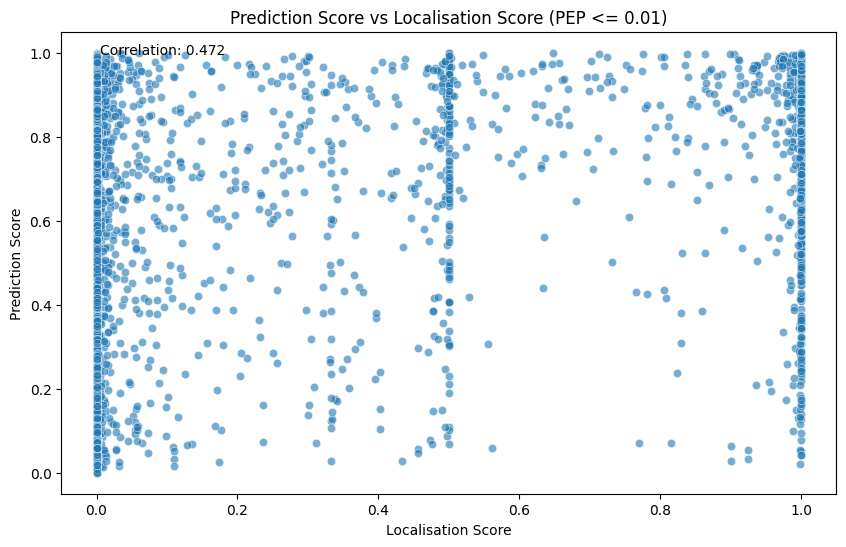

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data
filtered_df = merged_df[
    (~merged_df['Localisation_score'].isna()) & 
    (merged_df['PEP'] <= 0.01) & 
    (merged_df['Q.Value'] <= 0.01) & 
    (~merged_df['pred'].isna())
]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Localisation_score', y='pred', alpha=0.6)

# Add labels and title
plt.xlabel('Localisation Score')
plt.ylabel('Prediction Score')
plt.title('Prediction Score vs Localisation Score (PEP <= 0.01)')

# Add correlation coefficient
corr = filtered_df['Localisation_score'].corr(filtered_df['pred'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)

plt.show()

/tmp/ipykernel_4033189/3457588832.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pred_bin'] = pd.cut(filtered_df['pred'],


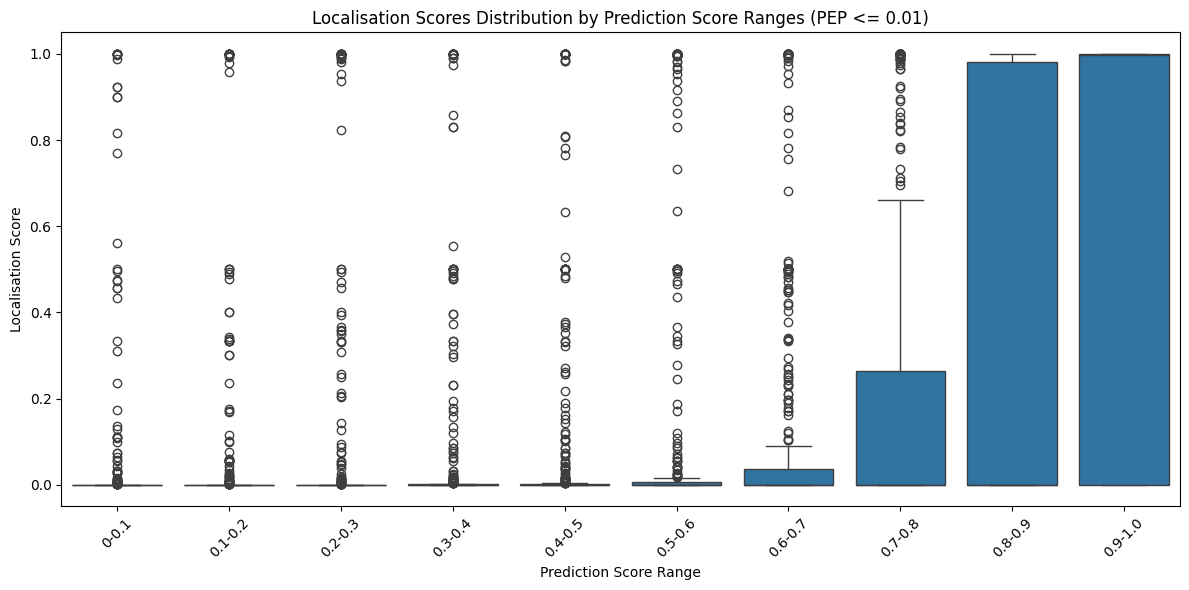


Number of samples in each prediction score range:
0-0.1       698
0.1-0.2     601
0.2-0.3     494
0.3-0.4     428
0.4-0.5     467
0.5-0.6     457
0.6-0.7     538
0.7-0.8     637
0.8-0.9     976
0.9-1.0    1861
Name: pred_bin, dtype: int64


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter the data
filtered_df = merged_df[
    (~merged_df['Localisation_score'].isna()) & 
    (merged_df['PEP'] <= 0.01) & 
    (~merged_df['pred'].isna())
]

# Create prediction score bins
filtered_df['pred_bin'] = pd.cut(filtered_df['pred'], 
                                bins=np.arange(0, 1.1, 0.1), 
                                labels=['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', 
                                       '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8',
                                       '0.8-0.9', '0.9-1.0'])

# Create figure
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(data=filtered_df, x='pred_bin', y='Localisation_score')

# Add labels and title
plt.xlabel('Prediction Score Range')
plt.ylabel('Localisation Score')
plt.title('Localisation Scores Distribution by Prediction Score Ranges (PEP <= 0.01)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print the number of samples in each bin
print("\nNumber of samples in each prediction score range:")
print(filtered_df['pred_bin'].value_counts().sort_index())

/tmp/ipykernel_4033189/716987825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pred_bin'] = pd.cut(filtered_df['pred'],


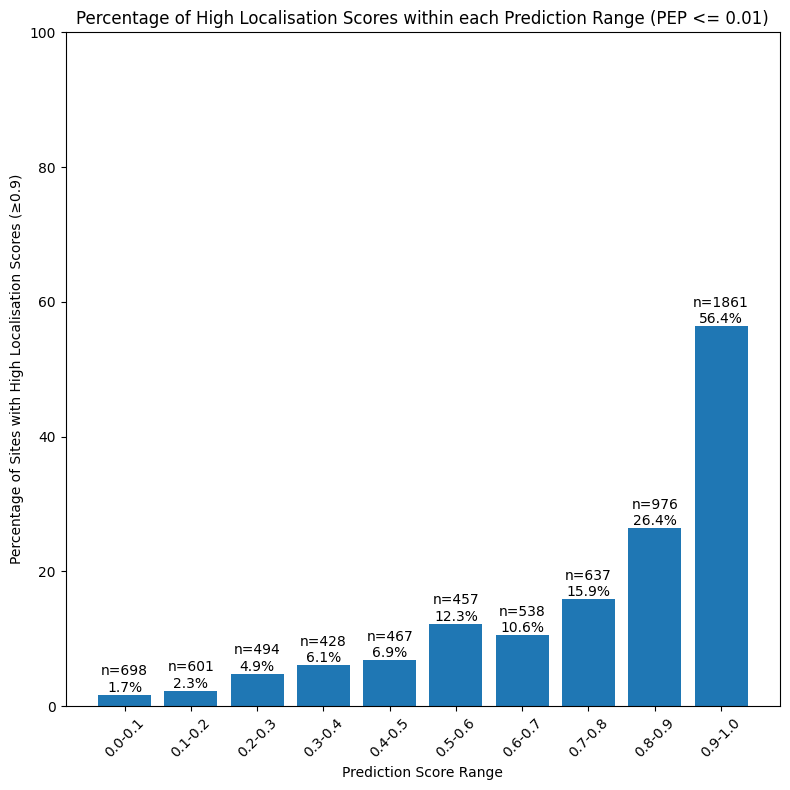

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data
filtered_df = merged_df[
    (~merged_df['Localisation_score'].isna()) & 
    (merged_df['PEP'] <= 0.01) & 
    (~merged_df['pred'].isna())
]

# Create prediction score bins with ordered labels
bin_labels = [f'{i/10:.1f}-{(i+1)/10:.1f}' for i in range(10)]
filtered_df['pred_bin'] = pd.cut(filtered_df['pred'], 
                                bins=np.arange(0, 1.1, 0.1), 
                                labels=bin_labels)

# Define high localization score (e.g., >= 0.7)
threshold = 0.9

# For each prediction bin, calculate:
# - total number of sites with a localization score
# - number of those sites with high localization score
# - percentage of high scoring sites
results = []
for bin_name in bin_labels:  # Use bin_labels to maintain order
    bin_data = filtered_df[filtered_df['pred_bin'] == bin_name]
    total_sites = len(bin_data)
    high_loc_sites = sum(bin_data['Localisation_score'] >= threshold)
    percentage = (high_loc_sites / total_sites * 100) if total_sites > 0 else 0
    results.append({
        'pred_bin': bin_name,
        'total_sites': total_sites,
        'percentage': percentage
    })

results_df = pd.DataFrame(results)

# Create figure
plt.figure(figsize=(8, 8))

# Create bar plot
bars = plt.bar(range(len(results_df)), results_df['percentage'])

# Add count labels on top of each bar
for i, (total, percentage) in enumerate(zip(results_df['total_sites'], results_df['percentage'])):
    plt.text(i, percentage, f'n={total}\n{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Prediction Score Range')
plt.ylabel(f'Percentage of Sites with High Localisation Scores (≥{threshold})')
plt.title(f'Percentage of High Localisation Scores within each Prediction Range (PEP <= 0.01)')

# Set x-axis labels
plt.xticks(range(len(results_df)), results_df['pred_bin'], rotation=45)

# Set y-axis to go from 0 to 100
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

localisation scores novel sites vs. training sites

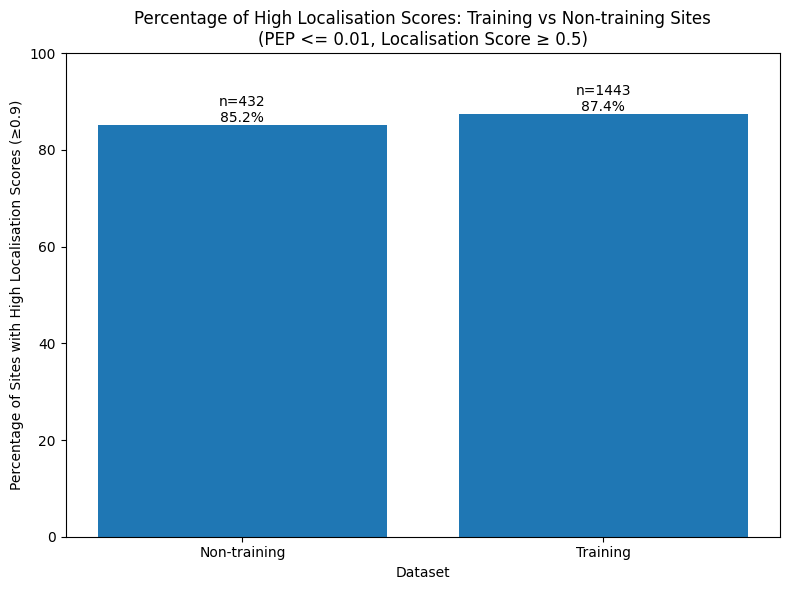

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data
filtered_df = merged_df[
    (~merged_df['Localisation_score'].isna()) & 
    (merged_df['PEP'] <= 0.01) & 
    (~merged_df['pred'].isna()) &
    (merged_df['Localisation_score'] >= 0.5)  # Only include substantial localization scores
]

# Define high localization score threshold
threshold = 0.9

# Calculate statistics for both groups
results = []
for training_status in [0, 1]:
    group_data = filtered_df[filtered_df['in_training'] == training_status]
    total_sites = len(group_data)
    high_loc_sites = sum(group_data['Localisation_score'] >= threshold)
    percentage = (high_loc_sites / total_sites * 100) if total_sites > 0 else 0
    results.append({
        'training_status': 'Training' if training_status == 1 else 'Non-training',
        'total_sites': total_sites,
        'percentage': percentage
    })

# Create figure
plt.figure(figsize=(8, 6))

# Create bar plot
bars = plt.bar(range(len(results)), [r['percentage'] for r in results])

# Add count labels on top of each bar
for i, result in enumerate(results):
    plt.text(i, result['percentage'], 
             f'n={result["total_sites"]}\n{result["percentage"]:.1f}%', 
             ha='center', va='bottom')

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel(f'Percentage of Sites with High Localisation Scores (≥{threshold})')
plt.title(f'Percentage of High Localisation Scores: Training vs Non-training Sites\n(PEP <= 0.01, Localisation Score ≥ 0.5)')

# Set x-axis labels
plt.xticks(range(len(results)), [r['training_status'] for r in results])

# Set y-axis to go from 0 to 100
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# 6. Comparing Baseline to filtered

In [34]:
orbitrap_020 = pd.read_parquet("/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet")
orbitrap_sites_020 = results_to_sites(orbitrap_020, peptides)
merged_df_020 = pd.merge(
    combined_df,
    orbitrap_sites_020,
    on=['prot_id', 'position'],
    how='left',
    indicator=True
)

# Create the 'found' column based on the _merge indicator
merged_df_020['found'] = (merged_df_020['_merge'] == 'both').astype(int)

# Drop the _merge column as we don't need it anymore
merged_df_020 = merged_df_020.drop('_merge', axis=1)

Processing peptidoforms: 100%|██████████| 3621/3621 [00:00<00:00, 24868.03it/s]


In [35]:
orbitrap_020 = pd.read_parquet("/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet")
orbitrap_sites_020 = results_to_sites(orbitrap_020, peptides)
merged_df_020 = pd.merge(
    combined_df,
    orbitrap_sites_020,
    on=['prot_id', 'position'],
    how='left',
    indicator=True
)

# Create the 'found' column based on the _merge indicator
merged_df_020['found'] = (merged_df_020['_merge'] == 'both').astype(int)

# Drop the _merge column as we don't need it anymore
merged_df_020 = merged_df_020.drop('_merge', axis=1)

Processing peptidoforms: 100%|██████████| 3621/3621 [00:00<00:00, 24938.06it/s]


In [36]:
merged_df_020.head()

,prot_id,position,pred,temp_key,in_training,Q.Value,PEP,Localisation_score,shared,found
0,A0A024R1R8,2,0.5218,A0A024R1R8_2,0,NaN,NaN,NaN,NaN,0
1,A0A024R1R8,3,0.5335,A0A024R1R8_3,0,NaN,NaN,NaN,NaN,0
2,A0A024R1R8,55,0.7344,A0A024R1R8_55,0,NaN,NaN,NaN,NaN,0
3,A0A024R1R8,61,0.6909,A0A024R1R8_61,0,NaN,NaN,NaN,NaN,0
4,A0A024RBG1,9,0.0712,A0A024RBG1_9,0,NaN,NaN,NaN,NaN,0


In [37]:
# Read and process each library
libraries = ['000','005', '010','020', '040', '080']
merged_dfs = {}

for lib in libraries:
    # Read parquet file
    orbitrap = pd.read_parquet(f"/public/compomics/sander/enriched/timsTOF_Pasef/diann_results/Enriched_{lib}_speclib.parquet")
    #orbitrap = pd.read_parquet(f"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_{lib}_speclib.parquet")
    
    # Process to sites
    orbitrap_sites = results_to_sites(orbitrap, peptides)
    
    # Merge with combined_df
    merged = pd.merge(
        combined_df,
        orbitrap_sites,
        on=['prot_id', 'position'],
        how='left',
        indicator=True
    )
    
    # Add found column and cleanup
    merged['found'] = (merged['_merge'] == 'both').astype(int)
    merged = merged.drop('_merge', axis=1)
    
    # Store in dictionary
    merged_dfs[lib] = merged

Processing peptidoforms: 100%|██████████| 12074/12074 [00:00<00:00, 27058.48it/s]


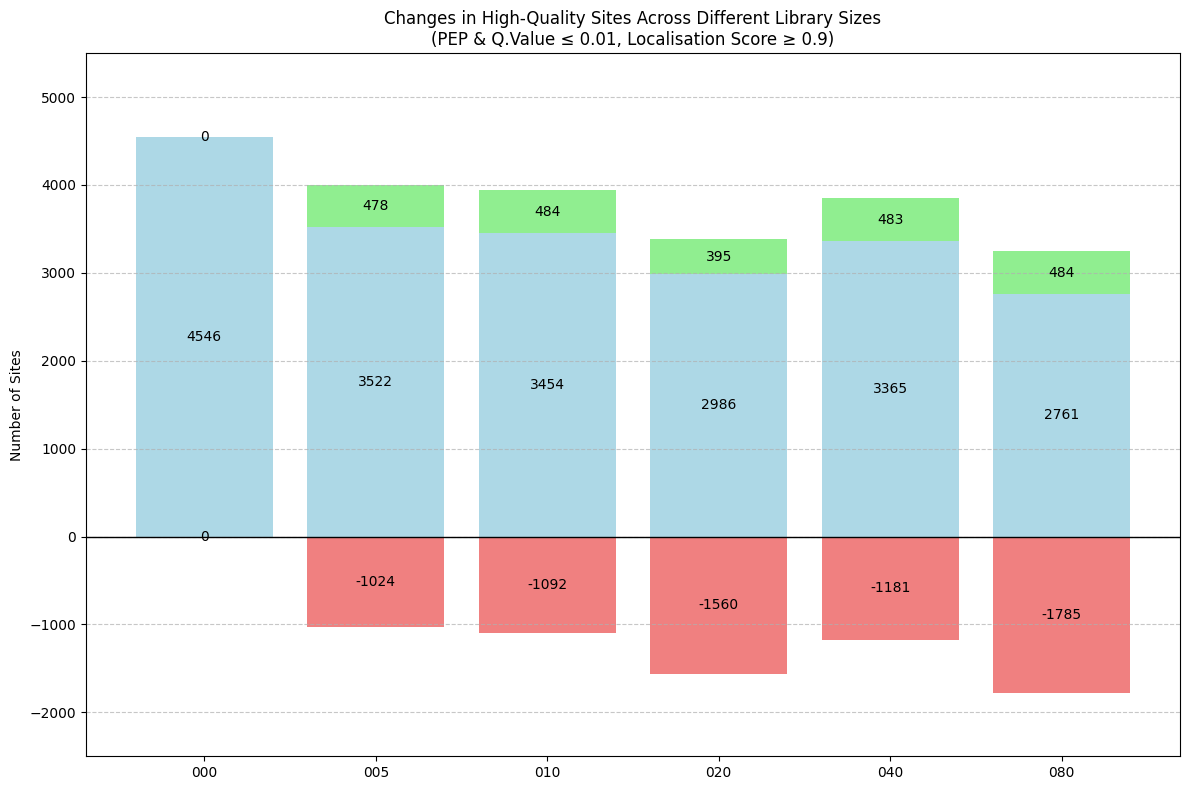

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def filter_df(df):
    return df[
        (df['PEP'] <= 0.01) & 
        (df['Q.Value'] <= 0.01) & 
        (df['Localisation_score'] >= 0.9)
    ]

def get_site_set(df):
    return set(zip(df['prot_id'], df['position']))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Reference dataset
ref_sites = get_site_set(filter_df(merged_dfs['000']))

# Process each library
libraries = ['000', '005', '010', '020', '040', '080']
x_positions = np.arange(len(libraries))

for idx, lib in enumerate(libraries):
    # Get sites for this library
    lib_sites = get_site_set(filter_df(merged_dfs[lib]))
    
    # Calculate statistics
    retained = len(ref_sites & lib_sites)
    lost = len(ref_sites - lib_sites)
    gained = len(lib_sites - ref_sites)
    
    # Create bars
    plt.bar(x_positions[idx], retained, color='lightblue', width=0.8)
    plt.bar(x_positions[idx], gained, bottom=retained, color='lightgreen', width=0.8)
    plt.bar(x_positions[idx], -lost, color='lightcoral', width=0.8)
    
    # Add value labels
    plt.text(x_positions[idx], retained/2, str(retained), ha='center', va='center')
    plt.text(x_positions[idx], retained + gained/2, str(gained), ha='center', va='center')
    plt.text(x_positions[idx], -lost/2, str(-lost), ha='center', va='center')

# Customize the plot
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Changes in High-Quality Sites Across Different Library Sizes\n(PEP & Q.Value ≤ 0.01, Localisation Score ≥ 0.9)')
plt.ylabel('Number of Sites')
plt.xticks(x_positions, libraries)

# Set y-axis limits
max_height = max([len(get_site_set(filter_df(df))) for df in merged_dfs.values()])
plt.ylim(-2500, 5500)

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

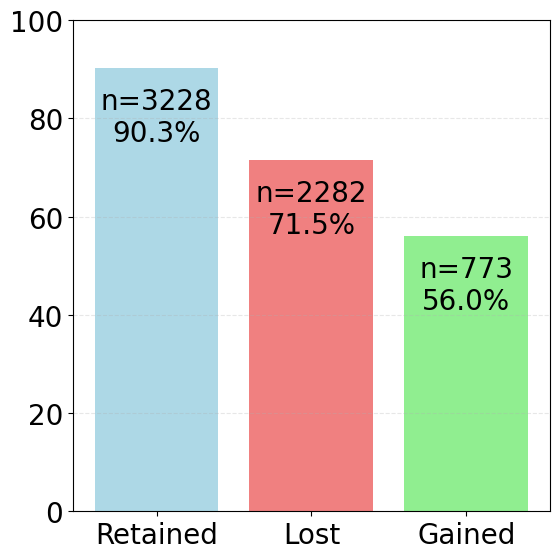

In [39]:
import matplotlib.pyplot as plt
import numpy as np

lib1, lib2 = '000', '080'  # Choose your libraries

# Set global font sizes
plt.rcParams.update({'font.size': 20})  # Default font size
plt.rcParams['axes.labelsize'] = 20     # Axis labels
plt.rcParams['xtick.labelsize'] = 20   # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 20    # Y-axis tick labels

# Filter both dataframes
def filter_df(df):
    return df[
        (df['PEP'] <= 0.01) & 
        (df['Q.Value'] <= 0.01) & 
        (df['Localisation_score'] >= 0.5)
    ]

df1 = filter_df(merged_dfs[lib1])
df2 = filter_df(merged_dfs[lib2])

# Get sets of sites with scores
def get_site_set_with_scores(df):
    return {(prot, pos): loc for prot, pos, loc in zip(df['prot_id'], df['position'], df['Localisation_score'])}

sites1 = get_site_set_with_scores(df1)
sites2 = get_site_set_with_scores(df2)

# Calculate high score threshold
threshold = 0.90

# Get stats for each category
def get_high_score_percentage(scores):
    if not scores:
        return 0, 0
    total = len(scores)
    high_scores = sum(1 for score in scores if score >= threshold)
    return (high_scores / total * 100), total

# Get scores for each category
retained_scores = [sites1[site] for site in set(sites1.keys()) & set(sites2.keys())]
lost_scores = [sites1[site] for site in set(sites1.keys()) - set(sites2.keys())]
gained_scores = [sites2[site] for site in set(sites2.keys()) - set(sites1.keys())]

# Calculate percentages and totals
retained_pct, retained_n = get_high_score_percentage(retained_scores)
lost_pct, lost_n = get_high_score_percentage(lost_scores)
gained_pct, gained_n = get_high_score_percentage(gained_scores)

# Create figure
plt.figure(figsize=(6, 6))

# Create bars with different colors
bars = plt.bar([0, 1, 2], 
               [retained_pct, lost_pct, gained_pct],
               color=['lightblue', 'lightcoral', 'lightgreen'])

# Add count labels inside each bar with larger font
for i, (n, pct) in enumerate([(retained_n, retained_pct), 
                             (lost_n, lost_pct), 
                             (gained_n, gained_pct)]):
    plt.text(i, pct-10,  # Subtract from pct to move text down inside bar
             f'n={n}\n{pct:.1f}%', 
             ha='center', 
             va='center',  # Changed to center vertical alignment
             fontsize=20,
             color='black')  # Ensure text is visible against bar colors
# Set x-axis labels
plt.xticks([0, 1, 2], ['Retained', 'Lost', 'Gained'], 
           fontsize=20)

# Set y-axis to go from 0 to 100
plt.ylim(0, 100)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

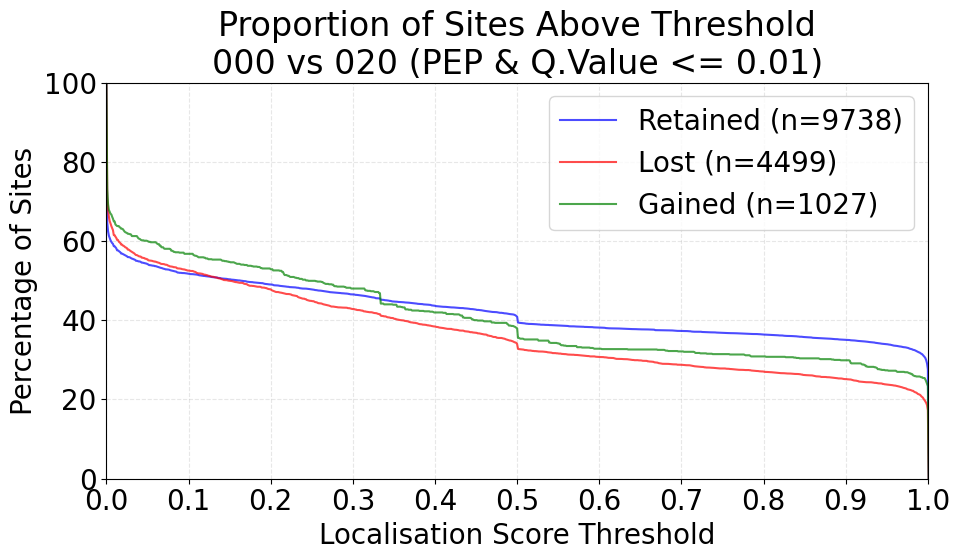

In [40]:
import matplotlib.pyplot as plt
import numpy as np

lib1, lib2 = '000', '020'  # Choose your libraries

# Filter dataframes (only for PEP, not for localization score)
def filter_df(df):
    return df[
        (df['PEP'] <= 0.01) & 
        (df['Q.Value'] <= 0.01)
    ]

df1 = filter_df(merged_dfs[lib1])
df2 = filter_df(merged_dfs[lib2])

# Get sets of sites with scores
def get_site_set_with_scores(df):
    return {(prot, pos): loc for prot, pos, loc in zip(df['prot_id'], df['position'], df['Localisation_score'])}

sites1 = get_site_set_with_scores(df1)
sites2 = get_site_set_with_scores(df2)

# Get categories
retained_sites = set(sites1.keys()) & set(sites2.keys())
lost_sites = set(sites1.keys()) - set(sites2.keys())
gained_sites = set(sites2.keys()) - set(sites1.keys())

# Get scores for each category
retained_scores = [sites1[site] for site in retained_sites]
lost_scores = [sites1[site] for site in lost_sites]
gained_scores = [sites2[site] for site in gained_sites]

# Create thresholds
thresholds = np.arange(0, 1.05, 0.001)

# Calculate proportions for each threshold
def get_proportions(scores):
    if not scores:
        return [0] * len(thresholds)
    proportions = []
    total = len(scores)
    for threshold in thresholds:
        high_scores = sum(1 for score in scores if score >= threshold)
        proportions.append((high_scores / total) * 100)
    return proportions

retained_props = get_proportions(retained_scores)
lost_props = get_proportions(lost_scores)
gained_props = get_proportions(gained_scores)

# Create plot
plt.figure(figsize=(10, 6))

# Plot lines without dots
plt.plot(thresholds, retained_props, '-', color='blue', label=f'Retained (n={len(retained_scores)})', alpha=0.7)
plt.plot(thresholds, lost_props, '-', color='red', label=f'Lost (n={len(lost_scores)})', alpha=0.7)
plt.plot(thresholds, gained_props, '-', color='green', label=f'Gained (n={len(gained_scores)})', alpha=0.7)

# Customize plot
plt.xlabel('Localisation Score Threshold')
plt.ylabel('Percentage of Sites')
plt.title(f'Proportion of Sites Above Threshold\n{lib1} vs {lib2} (PEP & Q.Value <= 0.01)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 100)

# Add x-axis gridlines at 0.1 intervals
plt.xticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()

Initial sizes after PEP/Q.Value filtering:
Library 000: 4546
Library 020: 3381

Unique sites in each library:
Library 000: 4546
Library 020: 3381

Sites by category:
Retained: 2986
Lost: 1560
Gained: 395


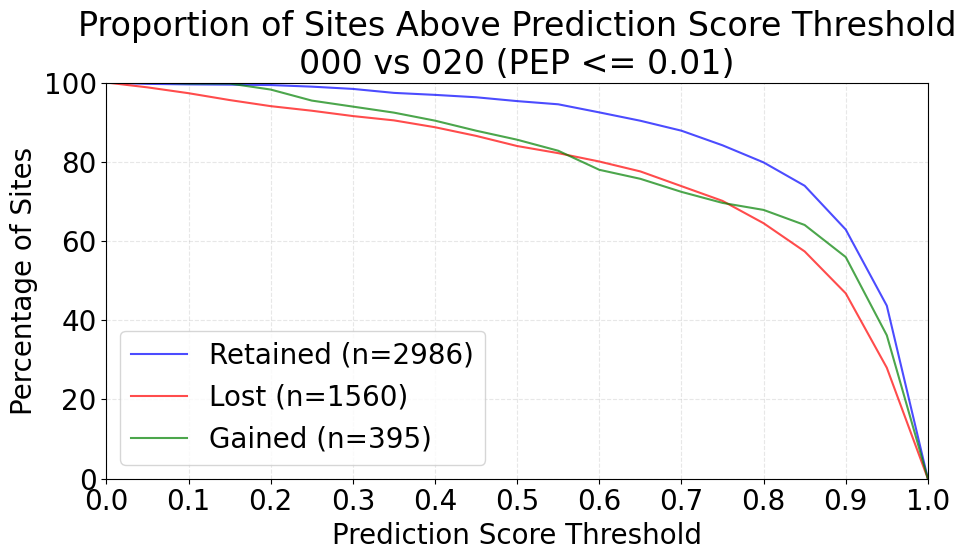

In [41]:
lib1, lib2 = '000', '020'  # Choose your libraries

# Filter dataframes and print initial sizes
def filter_df(df):
    filtered = df[
        (df['PEP'] <= 0.01) & 
        (df['Q.Value'] <= 0.01) &
        (df['Localisation_score'] >= 0.9) &
        (~df['pred'].isna())  # Make sure we have prediction scores
    ]
    return filtered

df1 = filter_df(merged_dfs[lib1])
df2 = filter_df(merged_dfs[lib2])

print(f"Initial sizes after PEP/Q.Value filtering:")
print(f"Library {lib1}: {len(df1)}")
print(f"Library {lib2}: {len(df2)}")

# Get unique sites with prediction scores
def get_site_set_with_scores(df):
    # Create a dictionary of unique prot_id-position combinations
    return {(prot, pos): pred for prot, pos, pred in 
            zip(df['prot_id'], df['position'], df['pred'])}

sites1 = get_site_set_with_scores(df1)
sites2 = get_site_set_with_scores(df2)

print(f"\nUnique sites in each library:")
print(f"Library {lib1}: {len(sites1)}")
print(f"Library {lib2}: {len(sites2)}")

# Get categories
retained_sites = set(sites1.keys()) & set(sites2.keys())
lost_sites = set(sites1.keys()) - set(sites2.keys())
gained_sites = set(sites2.keys()) - set(sites1.keys())

print(f"\nSites by category:")
print(f"Retained: {len(retained_sites)}")
print(f"Lost: {len(lost_sites)}")
print(f"Gained: {len(gained_sites)}")

# Get prediction scores for each category
retained_scores = [sites1[site] for site in retained_sites]
lost_scores = [sites1[site] for site in lost_sites]
gained_scores = [sites2[site] for site in gained_sites]

# Create thresholds
thresholds = np.arange(0, 1.05, 0.05)

# Calculate proportions for each threshold
def get_proportions(scores):
    if not scores:
        return [0] * len(thresholds)
    proportions = []
    total = len(scores)
    for threshold in thresholds:
        high_scores = sum(1 for score in scores if score >= threshold)
        proportions.append((high_scores / total) * 100)
    return proportions

retained_props = get_proportions(retained_scores)
lost_props = get_proportions(lost_scores)
gained_props = get_proportions(gained_scores)

# Create plot
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(thresholds, retained_props, '-', color='blue', label=f'Retained (n={len(retained_scores)})', alpha=0.7)
plt.plot(thresholds, lost_props, '-', color='red', label=f'Lost (n={len(lost_scores)})', alpha=0.7)
plt.plot(thresholds, gained_props, '-', color='green', label=f'Gained (n={len(gained_scores)})', alpha=0.7)

# Customize plot
plt.xlabel('Prediction Score Threshold')
plt.ylabel('Percentage of Sites')
plt.title(f'Proportion of Sites Above Prediction Score Threshold\n{lib1} vs {lib2} (PEP <= 0.01)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 100)

# Add x-axis gridlines at 0.1 intervals
plt.xticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()

data obtained from section 4. 

In [42]:
#Experimental
# Orbitrap Exploris 480
training_sites = [ 1211, 1144, 1299, 1181, 734, 627, 0]
novel_sites = [329, 313, 366, 315, 207, 171, 0]

# TimsTOF Pasef
training_sites = [ 3379, 2977, 2942, 2478, 2794, 2376, 0]
novel_sites = [ 846, 744, 713, 612, 692, 569, 0]

# Orbitrap AIF
training_sites = [ 41, 37, 55, 47, 13, 9, 4]
novel_sites = [ 9, 10, 14, 15, 4, 1, 0]

In [43]:
#Control
# Orbitrap Exploris 480
training_sites = [ 1211, 435, 422, 263, 0, 9, 0]
novel_sites = [329, 113, 107, 76, 0, 1, 0]

# TimsTOF Pasef
training_sites = [ 3379, 1208, 941, 510, 259, 64, 0]
novel_sites = [ 846, 271, 228, 115, 60, 9, 0]

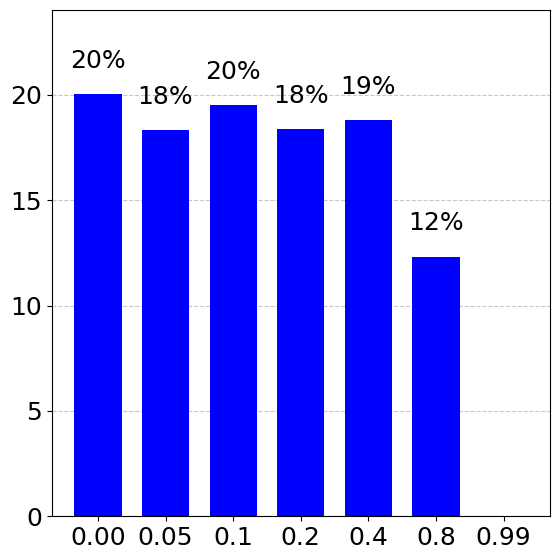

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the images
thresholds = ['0.00', '0.05', '0.1', '0.2', '0.4', '0.8', '0.99']
training_sites = [ 3379, 1208, 941, 510, 259, 64, 0]
novel_sites = [ 846, 271, 228, 115, 60, 9, 0]

# Calculate total sites and percentages
total_sites = [n + t for n, t in zip(novel_sites, training_sites)]
percentages = [100 * n / t if t > 0 else 0 for n, t in zip(novel_sites, total_sites)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create bar chart
bars = ax.bar(thresholds, percentages, color='blue', width=0.7)

# Increase tick label sizes
ax.tick_params(axis='both', which='major', labelsize=18)

# Add percentage and fraction labels above bars with larger font
for i, (perc, nov, tot) in enumerate(zip(percentages, novel_sites, total_sites)):
    if tot > 0:  # Avoid division by zero
        ax.text(i, perc + 1, f'{perc:.0f}%', 
                ha='center', va='bottom', fontsize=18)

# Set y-axis range with some padding for labels
ax.set_ylim(0, max(percentages) * 1.2)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Place gridlines behind bars

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()